In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from keras.models import Model, Input
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
import glob

In [2]:
# List all filename in face image path
filenames= glob.glob ('./face_mini/**/*.jpg')
size = len(filenames)
all_imgs = []
for i in range(size):
# Load image files and Resize (h,w,ch) -> h = w < 100 , ch = 3 (R,G,B)
    img = image.load_img(filenames[i], target_size=(100,100), interpolation="nearest")
# # convert the image to an array
    img = image.img_to_array(img)
# # Normalized color image
    img = img/255
    all_imgs.append(img)

# # convert to numpy array
all_imgs = np.array(all_imgs)
print(all_imgs.shape)
# # split data into train and validation data
train_x, test_x = train_test_split(all_imgs, random_state=32, test_size=0.3)
train_x, val_x = train_test_split(train_x, random_state=32, test_size=0.3)

(3203, 100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


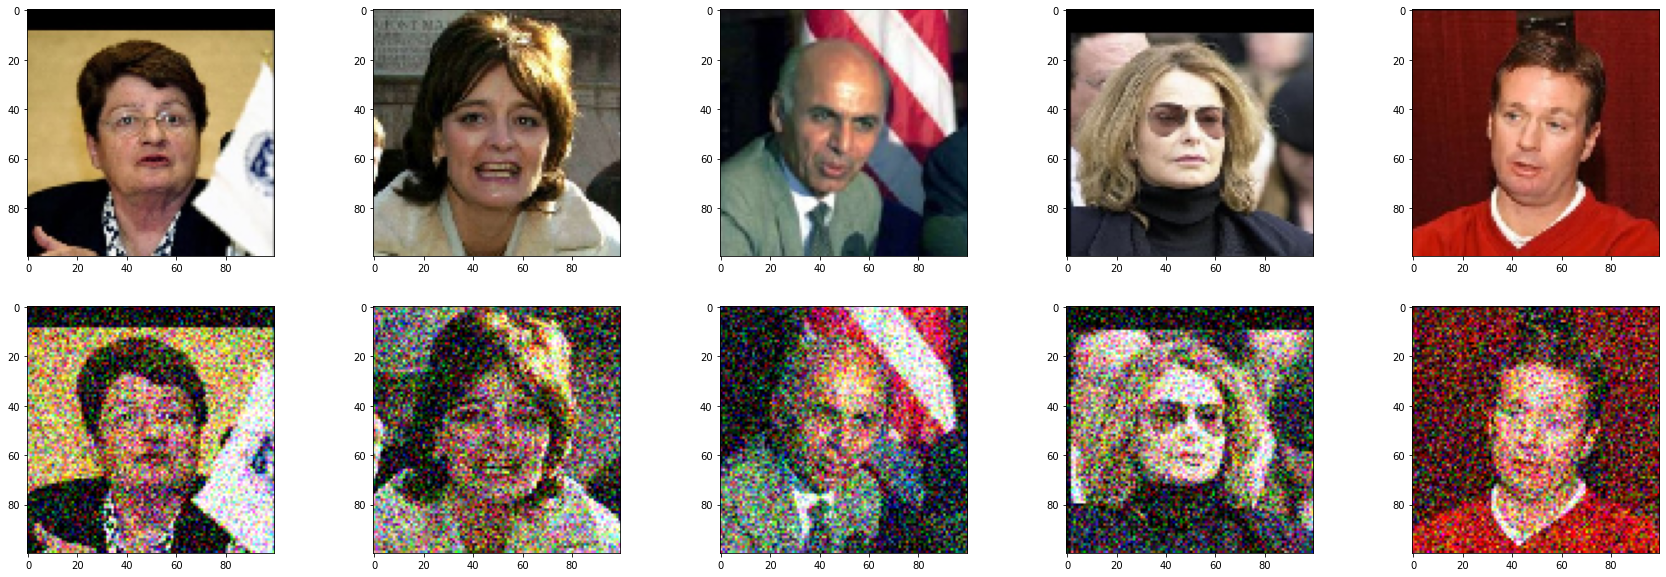

In [3]:
# Add Noise
noise_factor = [0.25,0.5]
Ndist = 'normal'
Nmean = 0
Nstd = 1


x_train_noisy = train_x + (noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=train_x.shape) )
x_val_noisy = val_x + ( noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=val_x.shape) )
x_test_noisy = test_x + ( noise_factor[0] * np.random.normal(loc=Nmean, scale=Nstd, size=test_x.shape) )

fig, axs = plt.subplots(2, 5,figsize=(30,10))
for i in range(5):
    img = train_x[i]
    axs[0,i].imshow(img)
for j in range(5):
    inoise = x_train_noisy[j]
    axs[1,j].imshow(inoise)
plt.show()


In [4]:
# กำหนด Encoder Architecture
input_img = Input(shape=inoise.shape)
#encoding architecture
x1 = Conv2D(256, (3, 3), activation='relu', padding='same')(input_img)
x2 = Conv2D(128, (3, 3), activation='relu', padding='same')(x1)
x2 = MaxPool2D( (2, 2))(x2)
encoded = Conv2D(64, (3, 3), activation='relu', padding='same')(x2)

# ก ําหนด Decoder Architecture
# decoding architecture
x3 = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x3 = UpSampling2D((2, 2))(x3)
x4 = Conv2D(128, (3, 3), activation='relu', padding='same')(x3)
x5 = Conv2D(256, (3, 3), activation='relu', padding='same')(x4)
decoded = Conv2D(3, (3, 3), padding='same')(x5)

# ก ําหนด optimizer setting
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mse') 
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 100, 100, 256)     7168      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 128)     295040    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        73792     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 64)        36928     
                                                             

Epoch 1/2
197/197 [==============================] - 340s 2s/step - loss: 0.0213 - val_loss: 0.0050
Epoch 2/2
197/197 [==============================] - 359s 2s/step - loss: 0.0041 - val_loss: 0.0039


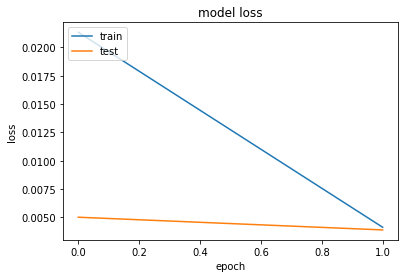

In [5]:
epoch = 2 #[ 2, 3, 4 ]
batch_size = 8 #[8, 16, 32]
early_stopper = EarlyStopping(monitor='val_loss')
history = autoencoder.fit (x_train_noisy, train_x,
epochs=2,
batch_size=8,
shuffle=True,
validation_data=(x_val_noisy, val_x),
callbacks=[early_stopper])

# ทดสอบ autoencoder model ด้วย validation
# predictions = autoencoder.predict(x_val_noisy)
predictions = autoencoder.predict(x_test_noisy)

# View Loss from history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

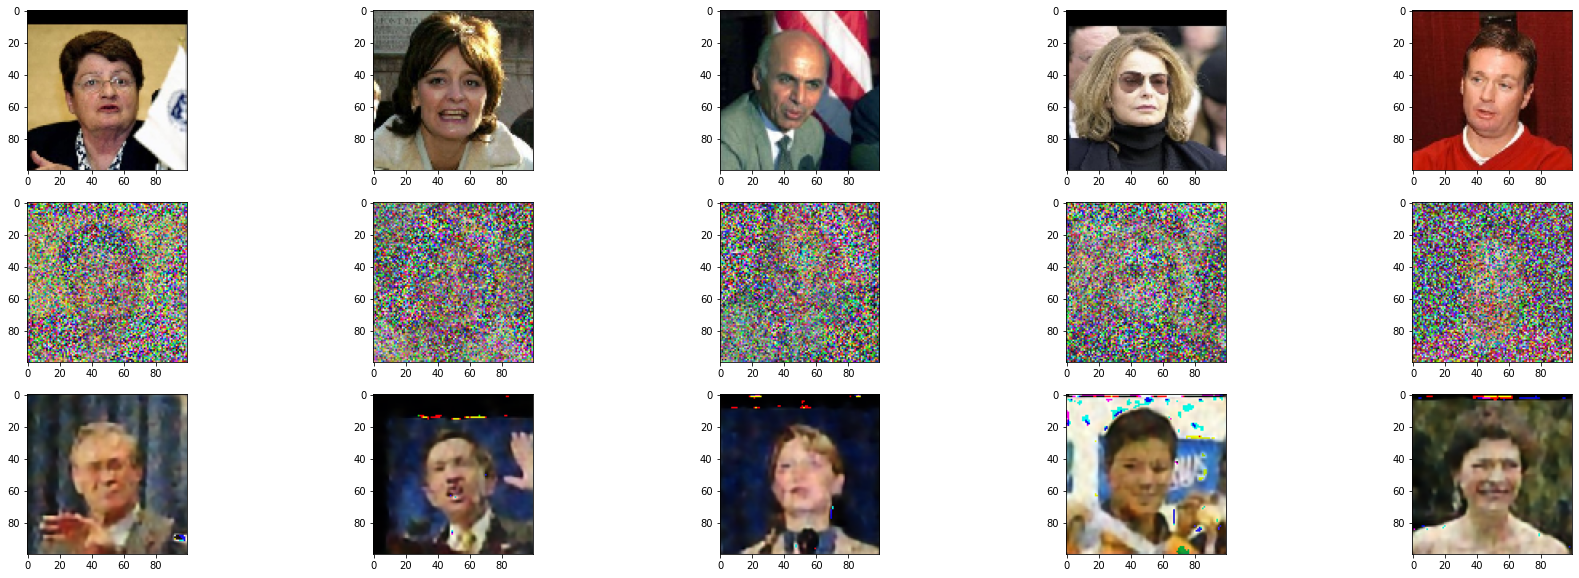

In [6]:
fig, axs = plt.subplots(3, 5,figsize=(30,10))
for i in range(5):
    img = train_x[i]
    axs[0,i].imshow((img * 255).astype(np.uint8))
for j in range(5):
    inoise = x_train_noisy[j]
    axs[1,j].imshow((inoise * 255).astype(np.uint8))
for k in range(5):
    ipredict = predictions[k]
    axs[2,k].imshow((ipredict * 255).astype(np.uint8))
plt.show()